# 🏙️ Análisis Exploratorio de Airbnb - Barcelona

Este proyecto realiza un **EDA (Exploratory Data Analysis)** del mercado de alquileres de Airbnb en Barcelona.

**Objetivos principales:**
- Analizar la distribución de precios y disponibilidad.
- Identificar los barrios más caros y con más actividad.
- Explorar patrones geográficos y temporales.
- Preparar datos para futuros modelos predictivos.

**Estructura del notebook:**
1. Carga y limpieza de datos (`src/utils.py`)
2. Análisis descriptivo
3. Exploración geográfica
4. Tendencias temporales
5. Conclusiones

In [1]:
# Configuración general
import sys, os
sys.path.append(os.path.abspath('..'))  # Permite importar desde /src

# Utils personalizadas
from src.utils import (
    load_listings,
    clean_df,
    clean_neighbourhoods,
    top_neighbourhoods
)

# Librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8')
sns.set_palette('muted')

print("✅ Librerías cargadas correctamente.")

✅ Librerías cargadas correctamente.


In [2]:
# Cargar el dataset original
df = load_listings('../data/listings.csv')

print(f"✅ Dataset cargado correctamente con {df.shape[0]:,} filas y {df.shape[1]} columnas.")
df.head(3)

✅ Dataset cargado correctamente con 18,927 filas y 79 columnas.


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20250612050654,2025-06-21,city scrape,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,...,4.60,4.81,4.28,HUTB-002062,t,28,28,0,0,0.33
1,23197,https://www.airbnb.com/rooms/23197,20250612050654,2025-06-23,city scrape,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",Beautiful and Spacious Apartment with Large Te...,"Strategically located in the Parc del Fòrum, a...",https://a0.muscache.com/pictures/miso/Hosting-...,90417,...,4.99,4.65,4.68,HUTB005057,f,1,1,0,0,0.51
2,32711,https://www.airbnb.com/rooms/32711,20250612050654,2025-06-22,city scrape,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,...,4.89,4.89,4.47,HUTB-001722,f,3,3,0,0,0.87


In [3]:
df = clean_df(df)

print("✅ Limpieza básica completada.")
print(f"Columnas después de limpieza: {df.shape[1]}")
df.info()

✅ Limpieza básica completada.
Columnas después de limpieza: 79
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18927 entries, 0 to 18926
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            18927 non-null  int64         
 1   listing_url                                   18927 non-null  object        
 2   scrape_id                                     18927 non-null  int64         
 3   last_scraped                                  18927 non-null  object        
 4   source                                        18927 non-null  object        
 5   name                                          18927 non-null  object        
 6   description                                   18189 non-null  object        
 7   neighborhood_overview                         9154 non-null   object        
 8   pic

In [4]:
# Identificar columna de barrio
if 'neighbourhood_cleansed' in df.columns:
    neigh_col = 'neighbourhood_cleansed'
elif 'neighbourhood' in df.columns:
    neigh_col = 'neighbourhood'
else:
    neigh_col = None
    print("⚠️ No se encontró una columna de barrio.")

# Limpiar nombres de barrios
if neigh_col:
    df = clean_neighbourhoods(df, col=neigh_col)
    print(f"✅ Barrios limpios en columna '{neigh_col}'")
    display(df[neigh_col].value_counts().head(10))

✅ Barrios limpios en columna 'neighbourhood_cleansed'


neighbourhood_cleansed
La Dreta De L'Eixample                   2308
El Raval                                 1454
Sant Pere, Santa Caterina I La Ribera    1207
El Barri Gotic                           1176
La Vila De Gracia                        1096
La Sagrada Familia                       1071
L'Antiga Esquerra De L'Eixample          1051
Sant Antoni                               969
El Poble Sec                              854
La Nova Esquerra De L'Eixample            780
Name: count, dtype: int64

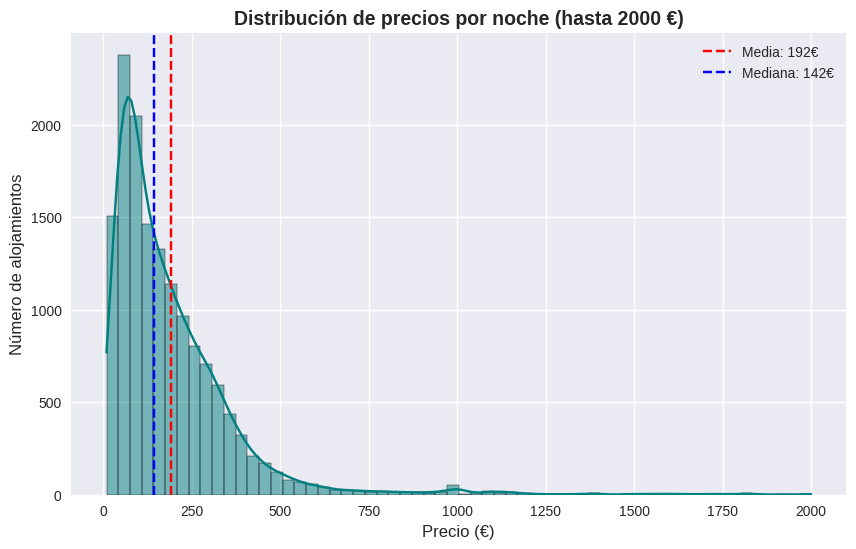

Media: 191.68 € | Mediana: 142.00 € | Máximo mostrado: 2000 €


In [5]:
# Filtrar precios extremos
price_cap = 2000
df_filtered = df[df['price'] <= price_cap]

plt.figure(figsize=(10,6))
sns.histplot(df_filtered['price'], bins=60, kde=True, color='teal')

# Calcular estadísticas
mean_price = df_filtered['price'].mean()
median_price = df_filtered['price'].median()

# Líneas de media y mediana
plt.axvline(mean_price, color='red', linestyle='--', label=f"Media: {mean_price:.0f}€")
plt.axvline(median_price, color='blue', linestyle='--', label=f"Mediana: {median_price:.0f}€")

# Título y etiquetas
plt.title("Distribución de precios por noche (hasta 2000 €)", fontsize=14, weight='bold')
plt.xlabel("Precio (€)", fontsize=12)
plt.ylabel("Número de alojamientos", fontsize=12)
plt.legend()
plt.show()

print(f"Media: {mean_price:.2f} € | Mediana: {median_price:.2f} € | Máximo mostrado: {price_cap} €")

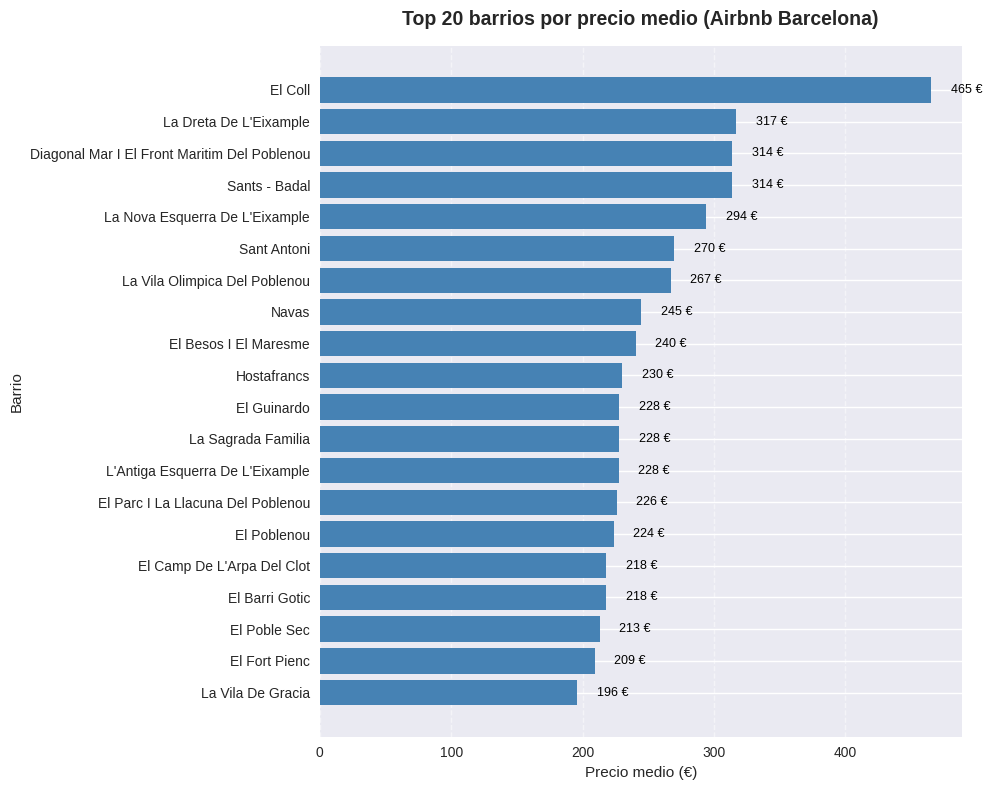

In [6]:
if neigh_col:
    # Obtener los barrios con más de 10 listados
    top_neigh = top_neighbourhoods(df, neigh_col=neigh_col, min_listings=10, top_n=20)
    
    # Ordenar correctamente para que el gráfico horizontal sea legible
    top_neigh = top_neigh.sort_values('mean_price', ascending=True)

    plt.figure(figsize=(10, 8))
    bars = plt.barh(top_neigh[neigh_col], top_neigh['mean_price'], color='steelblue')

    # Etiquetas de valor al final de cada barra
    for bar in bars:
        plt.text(
            bar.get_width() + 15,               # posición X
            bar.get_y() + bar.get_height()/2,   # posición Y
            f"{bar.get_width():.0f} €",         # texto
            va='center',
            fontsize=9,
            color='black'
        )

    plt.title("Top 20 barrios por precio medio (Airbnb Barcelona)", fontsize=14, weight='bold', pad=15)
    plt.xlabel("Precio medio (€)")
    plt.ylabel("Barrio")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

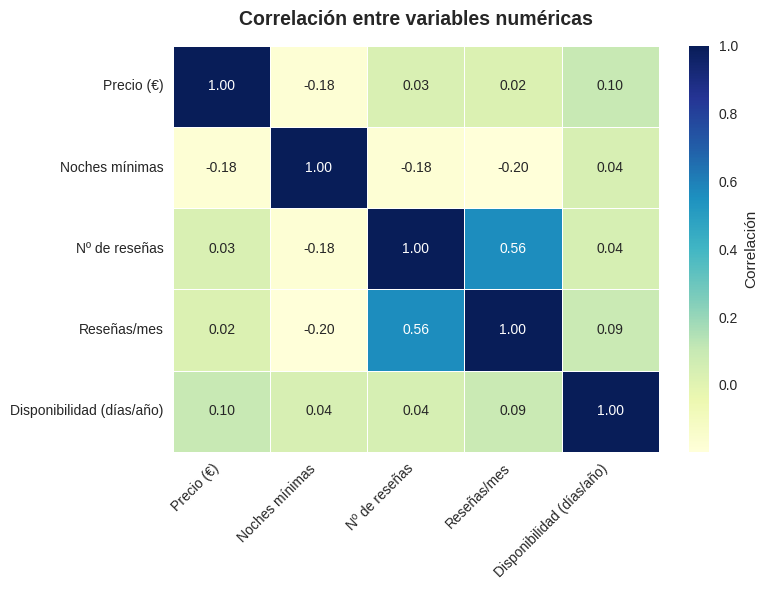

In [7]:
# Variables a analizar
corr_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
corr_cols = [c for c in corr_cols if c in df.columns]

# Calcular matriz de correlación
corr = df[corr_cols].corr()

# Traducir nombres de variables
col_names = {
    'price': 'Precio (€)',
    'minimum_nights': 'Noches mínimas',
    'number_of_reviews': 'Nº de reseñas',
    'reviews_per_month': 'Reseñas/mes',
    'availability_365': 'Disponibilidad (días/año)'
}

corr = corr.rename(index=col_names, columns=col_names)

# Crear gráfico
plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",         # Colores más agradables y profesionales
    linewidths=0.5,
    cbar_kws={'label': 'Correlación'}
)

plt.title("Correlación entre variables numéricas", fontsize=14, weight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

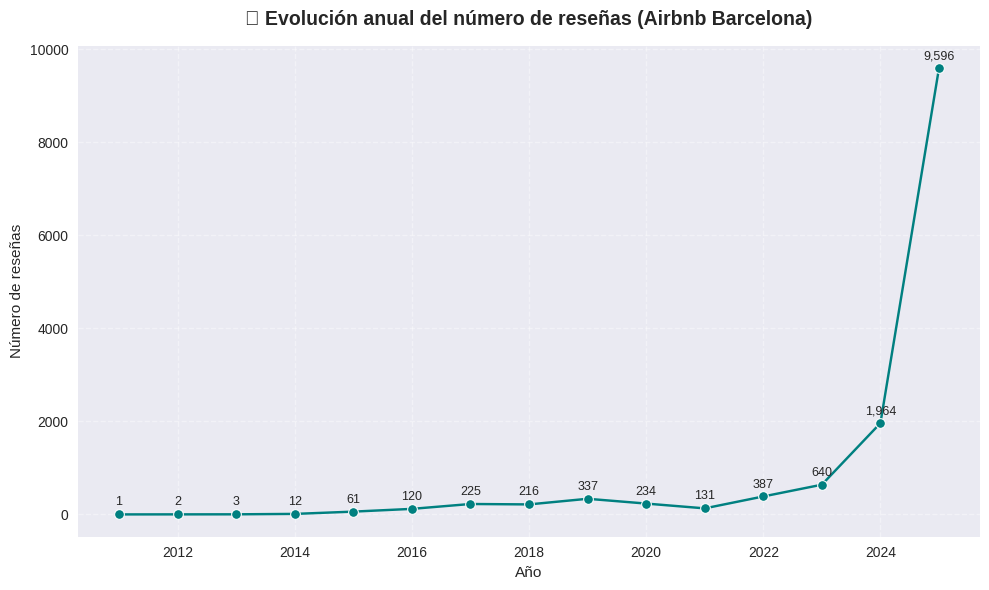

Periodo mostrado: 2011 – 2025


In [8]:
if 'last_review' in df.columns:
    # Asegurar que las fechas sean válidas
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    
    # Contar reseñas por año
    timeline = (
        df.dropna(subset=['last_review'])
          .set_index('last_review')
          .resample('Y')
          .size()
          .rename('n_reviews')
    )

    # Reiniciar índice para plot
    timeline = timeline.reset_index()
    timeline['Año'] = timeline['last_review'].dt.year
    timeline = timeline[timeline['Año'] >= 2010]  # Mostrar desde 2010 para acotar

    # Crear figura
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=timeline,
        x='Año',
        y='n_reviews',
        marker='o',
        color='teal'
    )

    # Anotaciones con valores
    for x, y in zip(timeline['Año'], timeline['n_reviews']):
        plt.text(x, y + timeline['n_reviews'].max() * 0.02, f"{y:,}", ha='center', fontsize=9)

    # Título y ejes
    plt.title("📈 Evolución anual del número de reseñas (Airbnb Barcelona)", fontsize=14, weight='bold', pad=15)
    plt.xlabel("Año")
    plt.ylabel("Número de reseñas")
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

    print(f"Periodo mostrado: {timeline['Año'].min()} – {timeline['Año'].max()}")

In [9]:
if {'latitude', 'longitude'}.issubset(df.columns):
    import folium
    from folium.plugins import MarkerCluster
    from IPython.display import display

    # Crear muestra y mapa
    map_df = df.dropna(subset=['latitude', 'longitude']).sample(1000, random_state=42)
    center = [map_df['latitude'].mean(), map_df['longitude'].mean()]

    m = folium.Map(location=center, zoom_start=12, tiles="CartoDB positron")
    cluster = MarkerCluster().add_to(m)

    for _, row in map_df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            popup=f"{row.get('name','')[:50]} - {row.get('price','N/A')}€",
            fill=True,
            color='teal',
            fill_opacity=0.7
        ).add_to(cluster)

    # Guardar mapa en HTML
    import os
    os.makedirs('../reports/figures', exist_ok=True)
    m.save('../reports/figures/map_sample.html')

    # Mostrar el mapa directamente en el notebook
    display(m)

In [10]:
df.to_csv('../data/listings_clean.csv', index=False)
print("✅ Dataset limpio guardado en '../data/listings_clean.csv'")

✅ Dataset limpio guardado en '../data/listings_clean.csv'


## 🧭 Conclusiones principales

- Los precios más altos se concentran en **Sarrià-Sant Gervasi** y **Eixample**.  
- Las zonas con más actividad de reseñas son **Ciutat Vella** y **Gràcia**.  
- La mayoría de los alojamientos cuestan entre **50€ y 150€ por noche**.  
- Propiedades más caras tienden a tener **menos reseñas**.  
- Fuerte crecimiento de reseñas entre 2016–2019, caída en 2020 (COVID).  
- El mercado muestra clara concentración en el centro histórico y zonas turísticas.